## How to simulate extra-tidal stars of globular clusters with a gaussian kick distribution using Corespray.

### STEP 0: Import the necessary Python packages. 

$\texttt{corespray}$ can be downloaded at: https://github.com/webbjj/corespray. 

$\texttt{galpy}$ (Bovy 2015) can be downloaded at: https://docs.galpy.org/en/v1.8.0/. 


In [1]:
# Import corespray:
from corespray import corespraydf,load_galpy_potential

# Import galpy packages:
from galpy.potential import MWPotential2014
from galpy.potential import KingPotential
from galpy.util import conversion
from galpy.orbit import Orbit

# Import other necessary Python packages:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from matplotlib import animation


from IPython.display import HTML
%matplotlib inline

### STEP 1: Load in the specific parameters for your GC of interest:
Spatial, kinematic and orbital parameters for most Galactic GCs can be found in the Baumgardt & Hilker (2018) catalogue. This catalogue is accessible at: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/. 

For this example, we simulate extra-tidal stars and binaries of M3. 

In [2]:
#Name of Galactic Globular Cluster from which to simulate core ejection or a Galpy orbit instance
gcname ='M3' 
#Potentional to be used for orbit integration (default: MWPotential2014)
potential = load_galpy_potential(bar=True,trans_arm=True)  # Galactic potential model
#globular cluster mass - needed if cluster's potential is to be included in orbit integration of escapers (default: None)
mgc = 4.06e5  # Mass [solar masses]
#half-mass radius of globular cluster (assuming Plummer potential) or tidal radius of globular cluster (assuming King potential) (default: None)
rgc = 127.28/1000.0  # Tidal radius of GC [kpc]
#King central potential parameter (default: None, which results in cluster potential taken to be a Plummer)
W0 = 8.61469762517307 
#mean kick velocity
vmean=100.
#standard deviation of kick velocity distribution
vsig=10.0
#galpy length scaling parameter (default: 8.)
ro = 8. #radius of the solar circle 
#galpy veocicity scaling parameter (default: 220.)
vo = 220. #circular orbit velocity at the solar circle

### STEP 2: Initialize a corespray instance using your previously defined parameters

In [3]:
# Initialize corespray
cspray = corespraydf(gcname, 
                     potential, 
                     mgc, rgc, W0, 
                     ro,vo)

### STEP 3: Sample core ejections along the orbit for 1000 Myr.


In [4]:
#time over which sampling begins (Myr)
tdisrupt=1000.0
#ejection rate (default 1 per Myr)
rate=1.0
#if set, nstar stars will be ejected randomly from -tdisrupt to 0 Myr. 
#Rate is recalculated. (default : None)
nstar=10
#when sampling kick velocity distribution function
#sampling range will be from 0 to npeak*vpeak, where 
#vpeak is the peak in the distribution function (default: 5)
npeak=5
#keep track of binaries that receive recoil kicks greater than 
#the cluster's escape velocity (default : False)
binaries=True

os = cspray.sample_gaussian(tdisrupt,rate,nstar,
                                 vmean,vsig,method='dop853_c')

### STEP 4: Extract parameters for the SINGLE escapers:

In [5]:
t_esc = cspray.tesc  # [Myr] in the past that star escaped
v_esc = cspray.vesc  # [km/s] kick velocity that star received

#### Explore some parameter spaces of your simulated extra-tidal stars
-- Note the cluster's orbit instance is set to cspray.o

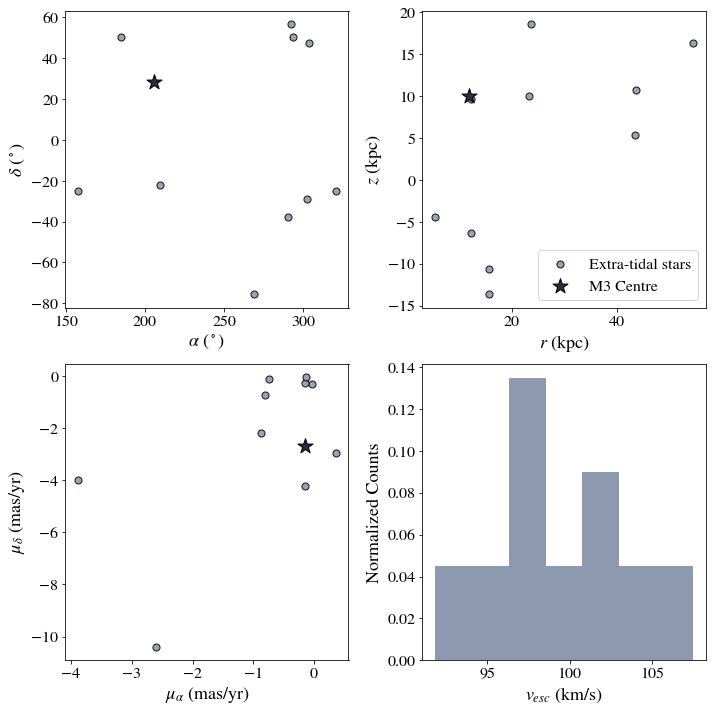

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# RA vs Dec positions:
ax[0, 0].scatter(os.ra(), os.dec(), marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[0, 0].scatter(cspray.o.ra(), cspray.o.dec(), marker='*', s=250, edgecolor='black', c='#2b2d42')
ax[0, 0].set_xlabel(r"$\alpha$ ($^\circ $)", fontsize=18)
ax[0, 0].set_ylabel(r"$\delta$ ($^\circ $)", fontsize=18)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].tick_params(axis='both', which='minor', labelsize=16)

# R vs z positions:
ax[0, 1].scatter(os.r(), os.z(), marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9, label='Extra-tidal stars') 
ax[0, 1].scatter(cspray.o.r(), cspray.o.z(), marker='*', s=250, edgecolor='black', c='#2b2d42', label='M3 Centre')
ax[0, 1].set_xlabel(r"$r$ (kpc)", fontsize=18)
ax[0, 1].set_ylabel(r"$z$ (kpc)", fontsize=18)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[0, 1].legend(fontsize=16)

# Proper motion:
ax[1, 0].scatter(os.pmra(), os.pmdec(), marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[1, 0].scatter(cspray.o.pmra(), cspray.o.pmdec(), marker='*', s=250, edgecolor='black', c='#2b2d42')
ax[1, 0].set_xlabel(r"$\mu_{\alpha}$ (mas/yr)", fontsize=18)
ax[1, 0].set_ylabel(r"$\mu_{\delta}$ (mas/yr)", fontsize=18)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].tick_params(axis='both', which='minor', labelsize=16)

# Escape velocities:
ax[1, 1].hist(v_esc, bins=7, color='#8d99ae', density=True)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[1, 1].set_xlabel(r"$v_{esc}$ (km/s)", fontsize=18)
ax[1, 1].set_ylabel("Normalized Counts", fontsize=18)

fig.tight_layout()
plt.show()

#### Animate the ejection of stars from the cluster's core

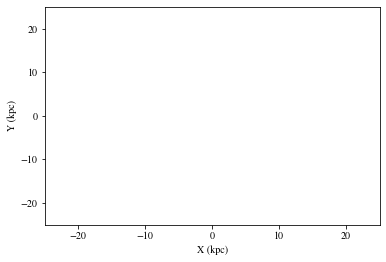

In [7]:
#frames - number of frames to use for animation (default:100)
#interval - time intercal between frames (default: 50 Myr)  
#xlim - xlimits for figure  
#ylim - ylimts for figure

cspray.animate(frames=100,interval=50,xlim=(-25,25),ylim=(-25,25))

In [8]:
HTML(cspray.anim.to_jshtml())


### Create Snapshot

In [9]:
#Output present day positions, velocities, escape times, and escape velocities of stars
#filename: file name to write data to (default: corespray.dat)
#filenameb: file name to write binary data to (default: corespray.dat)
cspray.snapout(filename='corespray_gaussian_transarm.dat')